In [1]:
import os
import math
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from pathlib import Path
from itertools import islice
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

warnings.filterwarnings("ignore")

2025-11-02 10:46:53.377091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 10:46:54.054445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup & Config

In [2]:
root_dir = "../dataset_4_100img"  # <-- CHANGE THIS

# === Run options ===
img_size = (224, 224)     # (height, width)
channels = 3              # Use 1 for grayscale
batch_size = 32
epochs = 50
seed = 42
augment = 1               # 1 to enable augmentations; 0 to disable
val_ratio = 0.15
test_ratio = 0.15
shuffle_on_epoch_end = True
num_workers = 2           # set >0 to enable multiprocessing in model.fit

# === File types to include ===
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# === Output directory for artifacts (models, plots) ===
out_dir = Path("outputs_custom_gen")
out_dir.mkdir(parents=True, exist_ok=True)

print("Config OK. Root:", root_dir)

Config OK. Root: ../dataset_4_100img


## 1) Scan Dataset & Build Manifest

In [3]:

def scan_dataset(root_dir, valid_exts):
    root = Path(root_dir)
    records = []
    classes = []
    for d in sorted(p.name for p in root.iterdir() if p.is_dir()):
        classes.append(d)
        for p in (root / d).rglob("*"):
            if p.is_file() and p.suffix.lower() in valid_exts:
                records.append({"filepath": str(p), "label": d})
    df = pd.DataFrame(records)
    # Map labels to indices
    class2idx = {c: i for i, c in enumerate(sorted(classes))}
    idx2class = {i: c for c, i in class2idx.items()}
    df["label_idx"] = df["label"].map(class2idx)
    return df, class2idx, idx2class

df_all, class2idx, idx2class = scan_dataset(root_dir, valid_exts)
num_classes = len(class2idx)

print("Found images:", len(df_all))
print("Classes:", class2idx)
df_all.head()

Found images: 467
Classes: {'Bacterial_Pneu': 0, 'COVID': 1, 'Normal': 2, 'Viral_Pneu': 3}


,filepath,label,label_idx
0,../dataset_4_100img/Bacterial_Pneu/Pneumonia-B...,Bacterial_Pneu,0
1,../dataset_4_100img/Bacterial_Pneu/Pneumonia-B...,Bacterial_Pneu,0
2,../dataset_4_100img/Bacterial_Pneu/Pneumonia-B...,Bacterial_Pneu,0
3,../dataset_4_100img/Bacterial_Pneu/Pneumonia-B...,Bacterial_Pneu,0
4,../dataset_4_100img/Bacterial_Pneu/Pneumonia-B...,Bacterial_Pneu,0


## 2) Class Distribution (Pre-Split)

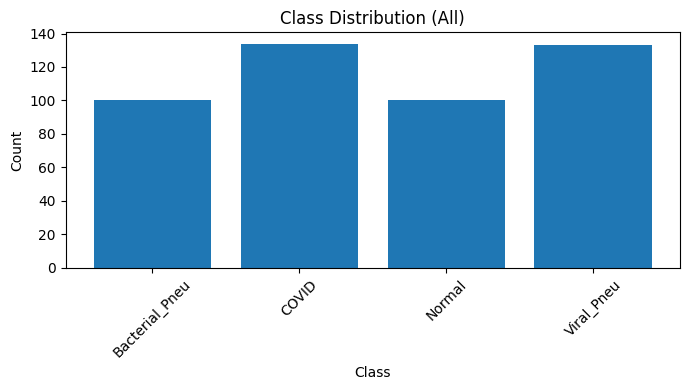

In [4]:

def plot_class_counts(df, title="Class Distribution", rotate=45):
    counts = df["label"].value_counts().sort_index()
    plt.figure(figsize=(7,4))
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=rotate)
    plt.tight_layout()
    plt.show()

plot_class_counts(df_all, title="Class Distribution (All)")

## 3) Stratified Train/Val/Test Split

In [5]:

def stratified_split(df, val_ratio, test_ratio, seed=42):
    # First split off test
    df_trainval, df_test = train_test_split(
        df, test_size=test_ratio, random_state=seed, stratify=df["label_idx"]
    )
    # Then split train vs val from remaining
    val_size = val_ratio / (1.0 - test_ratio)
    df_train, df_val = train_test_split(
        df_trainval, test_size=val_size, random_state=seed, stratify=df_trainval["label_idx"]
    )
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

df_train, df_val, df_test = stratified_split(df_all, val_ratio, test_ratio, seed)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))

Train: 326 Val: 70 Test: 71


### Post-Split Distributions

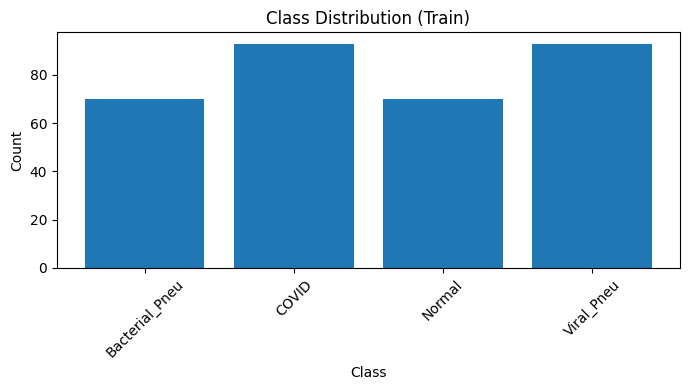

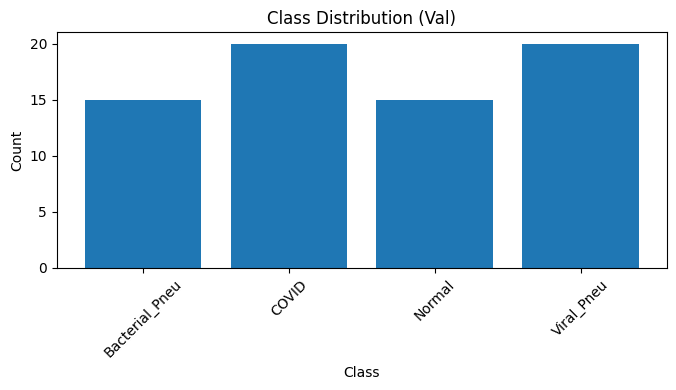

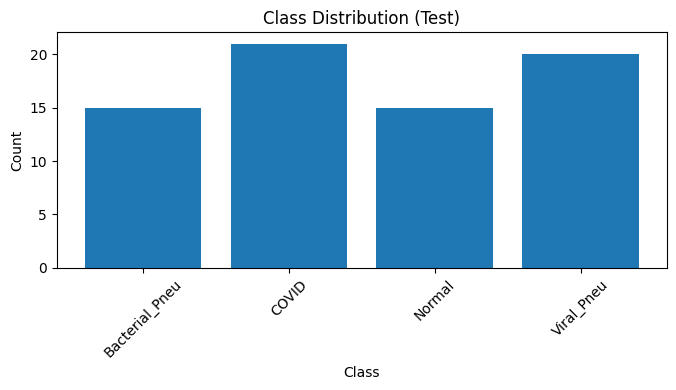

In [6]:
plot_class_counts(df_train, title="Class Distribution (Train)")
plot_class_counts(df_val,   title="Class Distribution (Val)")
plot_class_counts(df_test,  title="Class Distribution (Test)")

## 4) Custom Generator (with optional Augmentations)

In [7]:

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def load_image(path, target_size=(224, 224), channels=3):
    img = Image.open(path)
    if channels == 3:
        img = img.convert("RGB")
    else:
        img = img.convert("L")
    img = img.resize((target_size[1], target_size[0]))  # PIL: (width, height)
    arr = np.array(img, dtype=np.float32)
    if channels == 1:
        arr = np.expand_dims(arr, axis=-1)
    return arr

def basic_augment_pil(img: Image.Image):
    """
    Lightweight augmentations (only used if augment==1).
    You can extend this if needed.
    """
    # Random horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # Random rotation (-15 to +15 degrees)
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        img = img.rotate(angle, resample=Image.BILINEAR)
    # Random brightness
    if random.random() < 0.5:
        img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    # Random contrast
    if random.random() < 0.5:
        img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    return img

class CustomImageSequence(Sequence):
    def __init__(self, df, class2idx, batch_size=32, target_size=(224,224), channels=3,
                 shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.class2idx = class2idx
        self.batch_size = batch_size
        self.target_size = target_size
        self.channels = channels
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        # ceil to include the last partial batch if any
        return int(np.ceil(len(self.df) / self.batch_size)) if len(self.df) > 0 else 0

    def on_epoch_end(self):
        if self.shuffle and len(self.indices) > 0:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        # Compute safe slice for this batch
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.indices))

        # If start >= end, it's an invalid/empty batch -> tell Python we've finished
        if start >= end:
            raise IndexError

        sel = self.indices[start:end]
        batch_paths = self.df.loc[sel, "filepath"].tolist()
        batch_labels = self.df.loc[sel, "label_idx"].values

        X = np.zeros((len(batch_paths), self.target_size[0], self.target_size[1], self.channels), dtype=np.float32)
        y = np.zeros((len(batch_paths),), dtype=np.int32)

        for i, p in enumerate(batch_paths):
            img = Image.open(p)
            img = img.convert("RGB") if self.channels == 3 else img.convert("L")
            img = img.resize((self.target_size[1], self.target_size[0]))
            if self.augment:
                img = basic_augment_pil(img)
            arr = np.array(img, dtype=np.float32)
            if self.channels == 1:
                arr = np.expand_dims(arr, axis=-1)
            X[i] = arr
            y[i] = batch_labels[i]

        X = X / 255.0
        y = tf.keras.utils.to_categorical(y, num_classes=len(self.class2idx))
        return X, y

# Instantiate generators
train_gen = CustomImageSequence(df_train, class2idx, batch_size=batch_size,
                                target_size=img_size, channels=channels,
                                shuffle=True, augment=bool(augment))

val_gen   = CustomImageSequence(df_val, class2idx, batch_size=batch_size,
                                target_size=img_size, channels=channels,
                                shuffle=False, augment=False)

test_gen  = CustomImageSequence(df_test, class2idx, batch_size=batch_size,
                                target_size=img_size, channels=channels,
                                shuffle=False, augment=False)

print("Generators ready.")

Generators ready.


## 5) Augmentation Preview (if enabled)

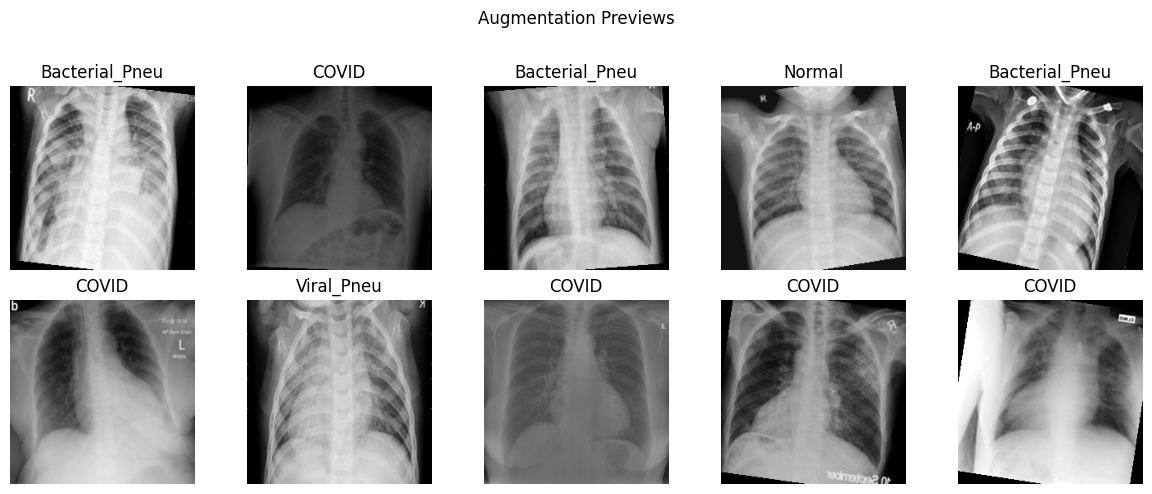

In [8]:

def show_augmentations(df, rows=2, cols=4, target_size=(224,224), channels=3):
    sample_paths = df.sample(min(rows*cols, len(df)), random_state=seed)["filepath"].tolist()
    plt.figure(figsize=(cols*2.4, rows*2.4))
    for i, p in enumerate(sample_paths):
        img = Image.open(p)
        img = img.convert("RGB") if channels == 3 else img.convert("L")
        img = img.resize((target_size[1], target_size[0]))
        aug_img = basic_augment_pil(img.copy())
        plt.subplot(rows, cols, i+1)
        plt.imshow(aug_img if channels == 3 else aug_img, cmap=None if channels==3 else "gray")
        plt.title(Path(p).parent.name)
        plt.axis("off")
    plt.suptitle("Augmentation Previews", y=1.02)
    plt.tight_layout()
    plt.show()

if augment:
    show_augmentations(df_train, rows=2, cols=5, target_size=img_size, channels=channels)
else:
    print("Augmentations disabled (set augment=1 to enable).")

## 6) Build a Simple CNN Model

In [9]:

def build_simple_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

input_shape = (img_size[0], img_size[1], channels)
model = build_simple_cnn(input_shape, num_classes)
model.summary()

2025-11-02 10:46:56.448899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-02 10:46:56.467615: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,764 (366.27 KB)

 Trainable params: 93,764 (366.27 KB)

 Non-trainable params: 0 (0.00 B)

## 7) Compile & Train (with Callbacks)

In [17]:
# JUPYTER CELL: Compile & train

ckpt_path = out_dir / "best_model.keras"

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cb = [
    callbacks.ModelCheckpoint(str(ckpt_path), monitor="val_accuracy", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=cb,
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.3781 - loss: 1.3667
Epoch 1: val_accuracy improved from -inf to 0.44286, saving model to outputs_custom_gen/best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 649ms/step - accuracy: 0.3777 - loss: 1.3667 - val_accuracy: 0.4429 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.3703 - loss: 1.3540
Epoch 2: val_accuracy did not improve from 0.44286
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 652ms/step - accuracy: 0.3724 - loss: 1.3534 - val_accuracy: 0.4286 - val_loss: 1.3259 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.3257 - loss: 1.3566
Epoch 3: val_accuracy improved from 0.44286 to 0.47143, saving model to outputs_custom_gen/best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 643ms/step - accuracy: 0.3305 - loss: 1.3547 - val_accuracy: 0.4714 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - a

## 8) Training & Validation Curves (Side-by-Side)

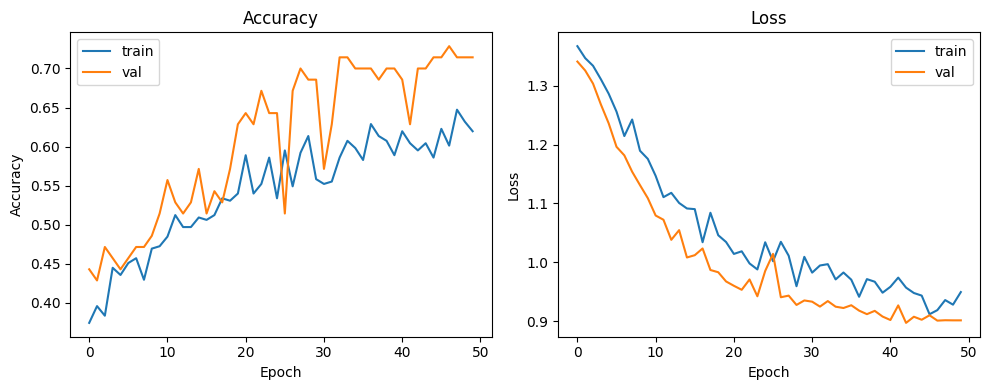

In [18]:
# JUPYTER CELL: Training curves

hist = history.history

plt.figure(figsize=(10,4))
# Left: accuracy
plt.subplot(1,2,1)
plt.plot(hist["accuracy"], label="train")
plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Right: loss
plt.subplot(1,2,2)
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


## 9) Evaluation on Test Set

In [19]:
# JUPYTER CELL: Evaluate

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6505 - loss: 0.9481
Test Loss: 0.9276 | Test Accuracy: 0.6761


## 10) Confusion Matrix (Counts + Normalized)

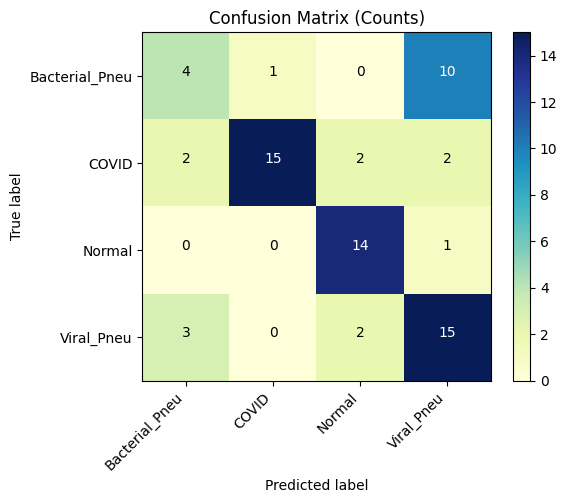

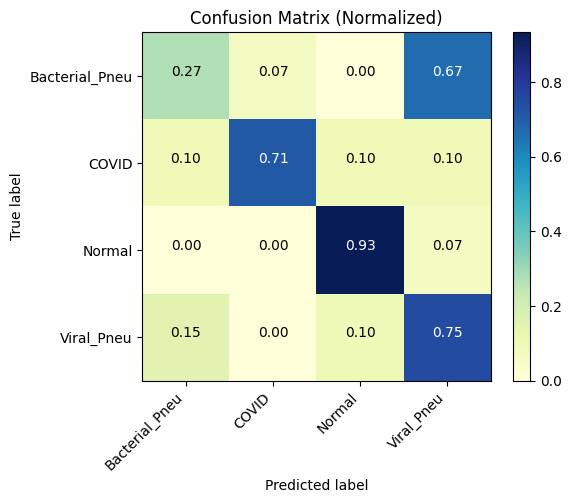

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Collect predictions & true labels
y_true = []
y_pred = []

for Xb, yb in test_gen:
    preds = model.predict(Xb, verbose=0)
    y_true.extend(np.argmax(yb, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_norm = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="true")

def plot_confusion_matrix(cm, classes, title="Confusion Matrix", normalize=False):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.YlGnBu)  # 💙 Blue color map added
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2. if not normalize else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_val = format(cm[i, j], fmt)
            plt.text(j, i, text_val,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# Define class names
class_names = [idx2class[i] for i in range(num_classes)]

# Plot both confusion matrices
plot_confusion_matrix(cm, class_names, title="Confusion Matrix (Counts)", normalize=False)
plot_confusion_matrix(cm_norm, class_names, title="Confusion Matrix (Normalized)", normalize=True)


## 11) Classification Report

In [21]:
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


                precision    recall  f1-score   support

Bacterial_Pneu     0.4444    0.2667    0.3333        15
         COVID     0.9375    0.7143    0.8108        21
        Normal     0.7778    0.9333    0.8485        15
    Viral_Pneu     0.5357    0.7500    0.6250        20

      accuracy                         0.6761        71
     macro avg     0.6739    0.6661    0.6544        71
  weighted avg     0.6864    0.6761    0.6656        71



## 12) ROC–AUC (Per-Class + Micro/Macro)

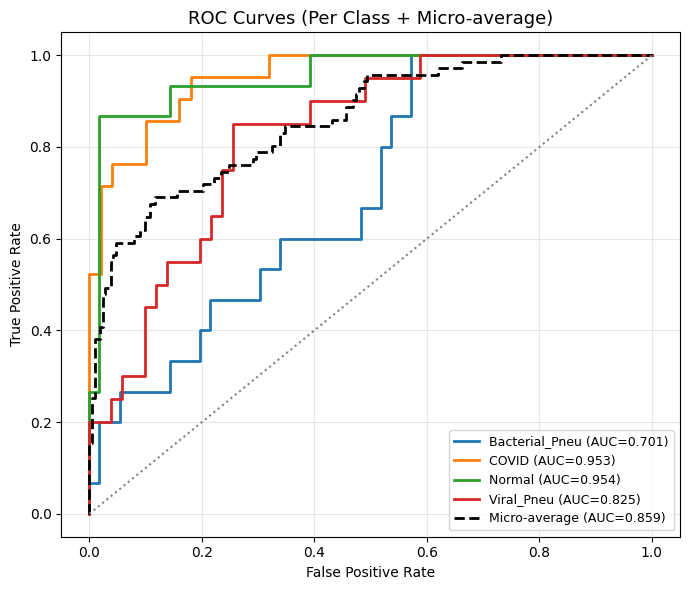

Macro-average AUC: 0.858


In [22]:
# JUPYTER CELL: Combined ROC–AUC Plot

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Collect predicted probabilities and true labels
y_true_oh = []
y_prob = []

for Xb, yb in test_gen:
    probs = model.predict(Xb, verbose=0)
    y_prob.append(probs)
    y_true_oh.append(yb)

y_prob = np.vstack(y_prob)       # (N, C)
y_true_oh = np.vstack(y_true_oh) # (N, C)

# ---- Compute micro-average ROC ----
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), y_prob.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# ---- Compute macro-average AUC ----
auc_per_class = []
for i in range(num_classes):
    fpr_i, tpr_i, _ = roc_curve(y_true_oh[:, i], y_prob[:, i])
    auc_per_class.append(auc(fpr_i, tpr_i))
auc_macro = np.mean(auc_per_class)

# ---- Plot both per-class and micro-average ROC ----
plt.figure(figsize=(7,6))

# Per-class ROC curves
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f"{class_names[i]} (AUC={roc_auc:.3f})")

# Micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color="black", linestyle="--", lw=2,
         label=f"Micro-average (AUC={auc_micro:.3f})")

# Diagonal line for random chance
plt.plot([0,1], [0,1], color="gray", linestyle=":")

# Formatting
plt.title("ROC Curves (Per Class + Micro-average)", fontsize=13)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Macro-average AUC: {auc_macro:.3f}")


## 13) Prediction Gallery (Correct = Green, Wrong = Red)

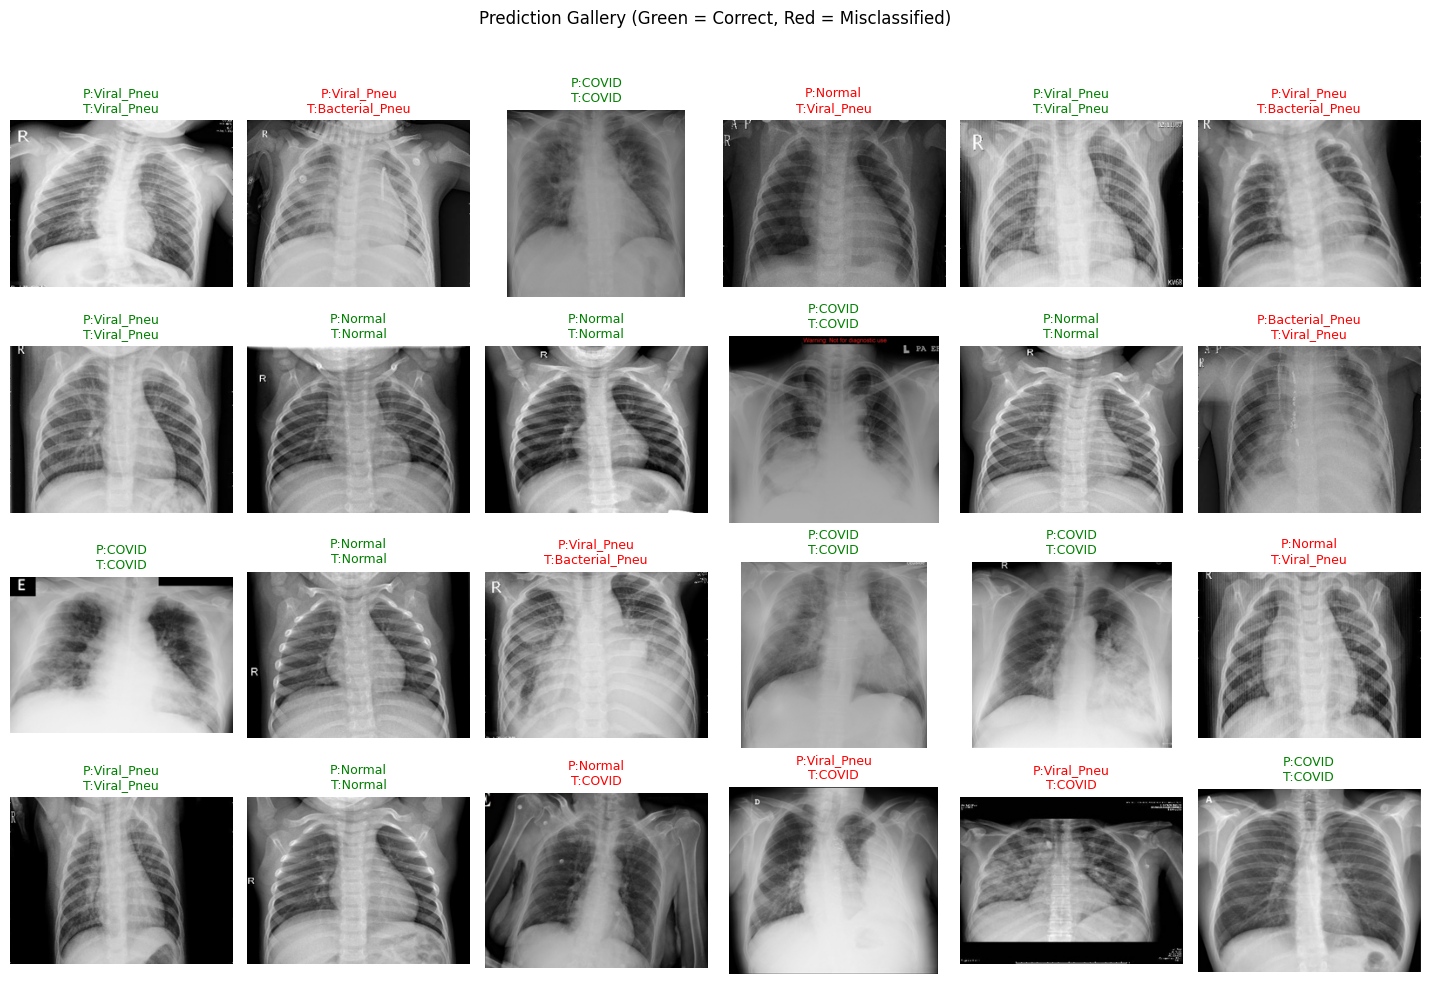

In [23]:



# Build a small gallery from test set
gallery_records = df_test.sample(min(24, len(df_test)), random_state=seed).reset_index(drop=True)

def draw_prediction_gallery(records, model, idx2class, target_size=(224,224), channels=3, cols=6):
    rows = math.ceil(len(records) / cols)
    plt.figure(figsize=(cols * 2.4, rows * 2.4))
    
    for i, row in records.iterrows():
        img = Image.open(row["filepath"])
        img = img.convert("RGB") if channels == 3 else img.convert("L")
        img_resized = img.resize((target_size[1], target_size[0]))
        arr = np.array(img_resized, dtype=np.float32)

        if channels == 1:
            arr = np.expand_dims(arr, axis=-1)
        arr = arr / 255.0

        # Predict
        pred_prob = model.predict(arr[None, ...], verbose=0)[0]
        pred_idx = int(np.argmax(pred_prob))
        true_idx = int(row["label_idx"])
        pred_label = idx2class[pred_idx]
        true_label = idx2class[true_idx]
        correct = (pred_idx == true_idx)

        # Plot
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img, cmap=None if channels == 3 else "gray")
        ax.set_title(f"P:{pred_label}\nT:{true_label}", fontsize=9, color=("green" if correct else "red"))
        ax.axis("off")

        # ✅ Green frame if correct, Red frame if misclassified
        edge_color = "green" if correct else "red"
        for spine in ax.spines.values():
            spine.set_edgecolor(edge_color)
            spine.set_linewidth(3.0)

    plt.suptitle("Prediction Gallery (Green = Correct, Red = Misclassified)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Call function
draw_prediction_gallery(gallery_records, model, idx2class, target_size=img_size, channels=channels, cols=6)
